<a href="https://colab.research.google.com/github/leogalbu/Mineral-Rocks-Image-Classification/blob/Model_1_Quartz_Pyrite_Binary/Model_2_Data_augmentation_Quartz_Pyrite_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [5]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

## Keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras import Sequential

## Download the data

In [1]:
!wget https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar

--2022-09-19 13:13:42--  https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar [following]
--2022-09-19 13:13:44--  https://www.dropbox.com/s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfed32ab2d5d7ca47271ec9a221.dl.dropboxusercontent.com/cd/0/inline/BtNm1lHSGMwJ_-dvCxfesXjkA420fFsWPnGkoCBSSfRE4Fclczr9FR_81bN1hBffeffZWVxG0gXei34D6vbzZLirom1DZH5HcFBamPZ_H5UKDooER098MYgPVRVN4MPO1WFF13asQUIuWf76TAQyn5-wlF-8PsBIC183qywcSnSLmg/file# [following]
--2022-09-19 13:13:45--  https://ucfed32ab2d5d7ca47271ec9a221.dl.dropboxusercontent.com/cd/0/inline/BtNm1lHSGMwJ_-dvCxfesXjkA420fFsWPnGkoCBSSfRE4Fclcz

## Extract the dataset

In [2]:
!unrar x "/content/QuartzPyriteImages.rar" "/content/QuartzPyriteImages/";


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/QuartzPyriteImages.rar

Creating    /content/QuartzPyriteImages                               OK
Creating    /content/QuartzPyriteImages/train                         OK
Creating    /content/QuartzPyriteImages/train/Pyrite                  OK
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1.jpg          0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1002.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1004.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1005.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1007.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1008.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1011.jpg       0%  OK 
Extracting  /conten

## Setting the train, validation and test directory

In [3]:
train_dir = 'QuartzPyriteImages/train'
val_dir = 'QuartzPyriteImages/validation'
test_dir = 'QuartzPyriteImages/test'

## Scanning the directories (Before checking the correct images)

In [6]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 238 images in 'QuartzPyriteImages/validation/Quartz'
the are 0 directories, and 260 images in 'QuartzPyriteImages/validation/Pyrite'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 713 images in 'QuartzPyriteImages/train/Quartz'
the are 0 directories, and 778 images in 'QuartzPyriteImages/train/Pyrite'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 238 images in 'QuartzPyriteImages/test/Quartz'
the are 0 directories, and 260 images in 'QuartzPyriteImages/test/Pyrite'


## Scanning all the images and remove the not formatted well

In [7]:
from struct import unpack
from tqdm import tqdm_notebook
import pathlib
data_dir = [pathlib.Path(val_dir), pathlib.Path(train_dir), pathlib.Path(test_dir)]
data_dir

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")       


bads = []
for dir in data_dir:
  print(dir)
  for img in tqdm_notebook(list(dir.glob('*/*.jpg'))):
      image = str(img)
      image = JPEG(image) 
      try:
          image.decode()   
      except:
          os.remove(img)
          bads.append(img)

QuartzPyriteImages/validation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/498 [00:00<?, ?it/s]

QuartzPyriteImages/train


  0%|          | 0/1490 [00:00<?, ?it/s]

QuartzPyriteImages/test


  0%|          | 0/498 [00:00<?, ?it/s]

## Scanning the directories (After checking the correct images)

---



In [8]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 236 images in 'QuartzPyriteImages/validation/Quartz'
the are 0 directories, and 237 images in 'QuartzPyriteImages/validation/Pyrite'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 709 images in 'QuartzPyriteImages/train/Quartz'
the are 0 directories, and 695 images in 'QuartzPyriteImages/train/Pyrite'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 236 images in 'QuartzPyriteImages/test/Quartz'
the are 0 directories, and 240 images in 'QuartzPyriteImages/test/Pyrite'


## Loading Datasets with image_dataset_from_directory



In [9]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
print('Setting up Training data')
train_data_set = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Validation data')
validation_data_set = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Test data')
test_data_set = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')

Setting up Training data
Found 1403 files belonging to 2 classes.
Setting up Validation data
Found 473 files belonging to 2 classes.
Setting up Test data
Found 476 files belonging to 2 classes.


## View Random Images

In [10]:
class_names = train_data_set.class_names
class_names

['Pyrite', 'Quartz']

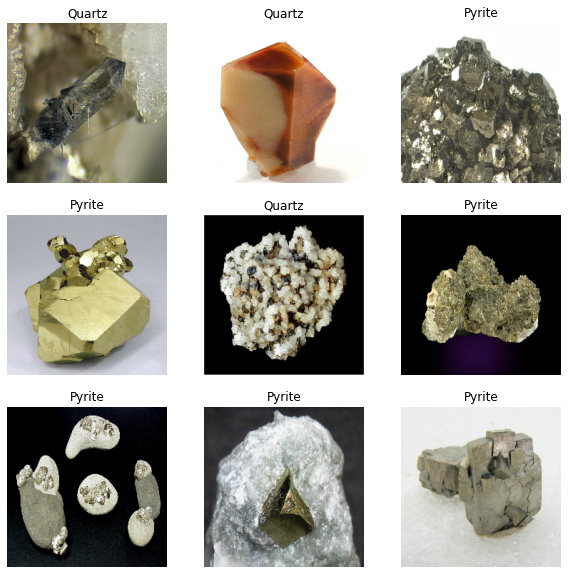

In [11]:
class_names = train_data_set.class_names
plt.figure(figsize=(10,10))
for images, labels in train_data_set.take(1):
  lbl = labels.numpy().ravel().astype('int')
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis('off')

## Build the Model with data agumentation

In [18]:
from tensorflow.keras.layers.experimental import preprocessing

model_2_data_augmentation = Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    Conv2D(32,3, input_shape=(224,224,3), activation='relu'),
    MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    Conv2D(256,3, activation='relu'),
    MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
model_2_data_augmentation.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [20]:
history_2_data_augmentation = model_2_data_augmentation.fit(train_data_set, epochs=20, steps_per_epoch=len(train_data_set), validation_data=test_data_set, validation_steps=len(test_data_set))

Epoch 1/20
44/44 [==============================] - 21s 153ms/step - loss: 0.9797 - accuracy: 0.5952 - val_loss: 0.6582 - val_accuracy: 0.6681
Epoch 2/20
44/44 [==============================] - 6s 128ms/step - loss: 0.5622 - accuracy: 0.7177 - val_loss: 0.5013 - val_accuracy: 0.8025
Epoch 3/20
44/44 [==============================] - 6s 130ms/step - loss: 0.4792 - accuracy: 0.7876 - val_loss: 0.4132 - val_accuracy: 0.8319
Epoch 4/20
44/44 [==============================] - 6s 128ms/step - loss: 0.4643 - accuracy: 0.7969 - val_loss: 0.4806 - val_accuracy: 0.8067
Epoch 5/20
44/44 [==============================] - 6s 127ms/step - loss: 0.4548 - accuracy: 0.7897 - val_loss: 0.4562 - val_accuracy: 0.8172
Epoch 6/20
44/44 [==============================] - 6s 129ms/step - loss: 0.4240 - accuracy: 0.8147 - val_loss: 0.4332 - val_accuracy: 0.8298
Epoch 7/20
44/44 [==============================] - 6s 129ms/step - loss: 0.4241 - accuracy: 0.8104 - val_loss: 0.4203 - val_accuracy: 0.8403
Epoch

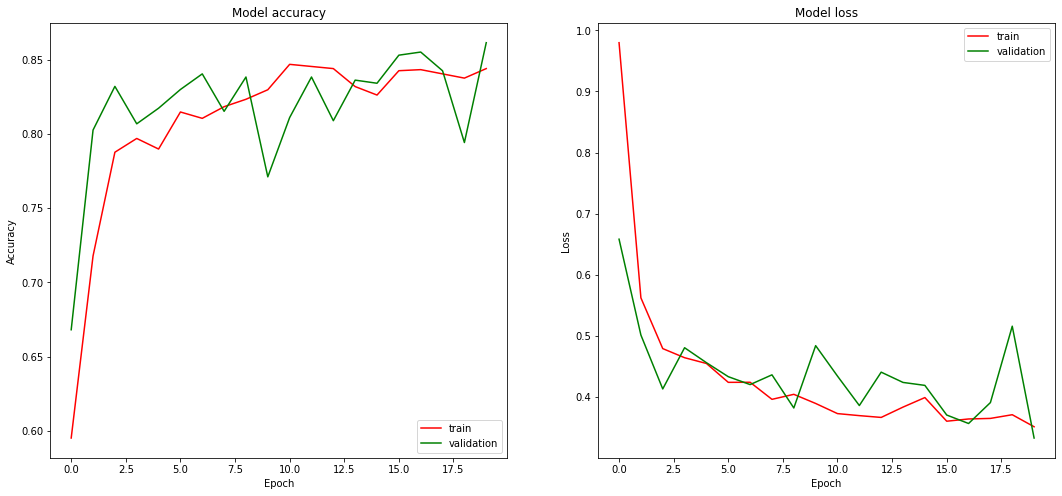

In [21]:
def plot_performance(model_history):
    # modle performance visualization
    # subplot
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # accuracy
    ax1.plot(model_history.history['accuracy'], color='red')
    ax1.plot(model_history.history['val_accuracy'], color='green')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # "Loss"
    ax2.plot(model_history.history['loss'], color='red')
    ax2.plot(model_history.history['val_loss'], color='green')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_performance(history_2_data_augmentation)